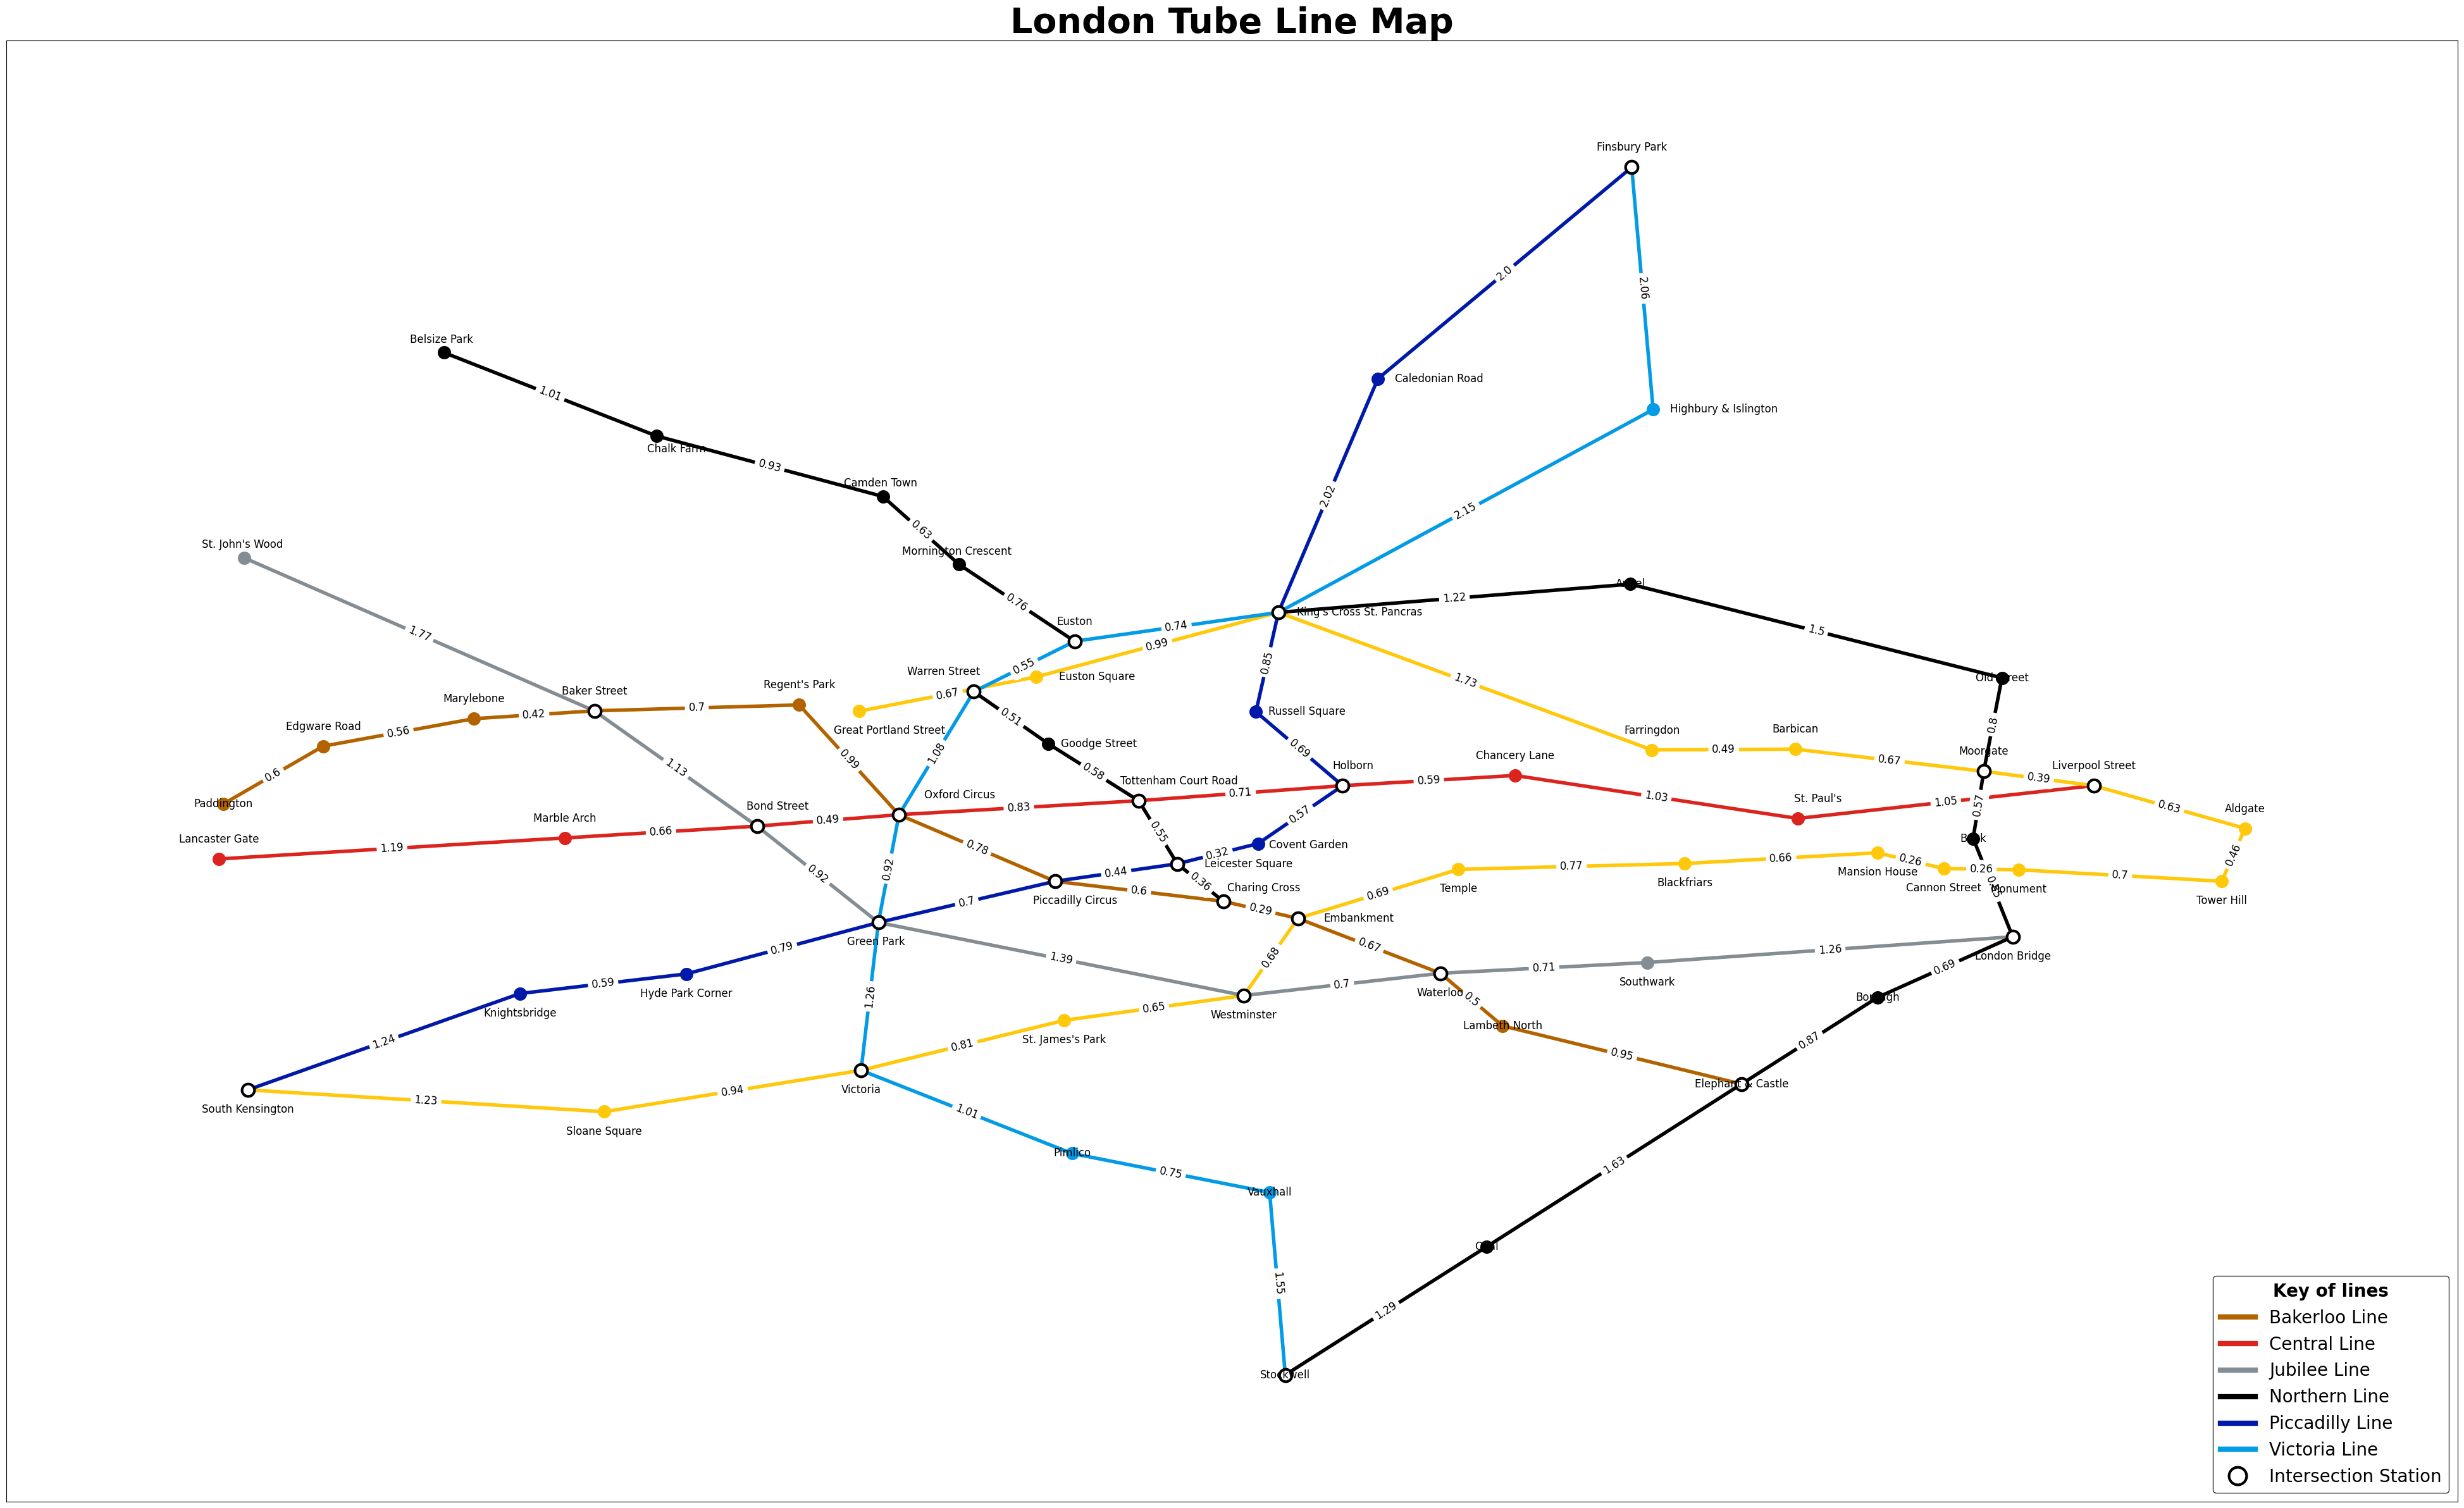

Total length of the transport network: 74.14 km
Average distance between stations: 0.87 km
Standard deviation of distances between stations: 0.42 km


In [5]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ------------------- Data Loading -------------------
# Load the CSV file
file_path = 'London stations.csv'  # Replace with the actual file path
stations_data = pd.read_csv(file_path)
stations_data.columns = stations_data.columns.str.strip()  # Remove extra spaces

# ------------------- Haversine Function -------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ------------------- Graph Data Preparation -------------------
bakerloo_line_edges = [
    ("Elephant & Castle", "Lambeth North"),
    ("Lambeth North", "Waterloo"),
    ("Waterloo", "Embankment"),
    ("Embankment", "Charing Cross"),
    ("Charing Cross", "Piccadilly Circus"),
    ("Piccadilly Circus", "Oxford Circus"),
    ("Oxford Circus", "Regent's Park"),
    ("Regent's Park", "Baker Street"),
    ("Baker Street", "Marylebone"),
    ("Marylebone", "Edgware Road"),
    ("Edgware Road", "Paddington"),
]

central_line_edges = [
    ("Lancaster Gate", "Marble Arch"),
    ("Marble Arch", "Bond Street"),
    ("Bond Street", "Oxford Circus"),
    ("Oxford Circus", "Tottenham Court Road"),
    ("Tottenham Court Road", "Holborn"),
    ("Holborn", "Chancery Lane"),
    ("Chancery Lane", "St. Paul's"),
    ("St. Paul's", "Liverpool Street"),
]

circle_line_edges = [
    ("Great Portland Street", "Euston Square"),
    ("Euston Square", "King's Cross St. Pancras"),
    ("King's Cross St. Pancras", "Farringdon"),
    ("Farringdon", "Barbican"),
    ("Barbican", "Moorgate"),
    ("Moorgate", "Liverpool Street"),
    ("Liverpool Street", "Aldgate"),
    ("Aldgate", "Tower Hill"),
    ("Tower Hill", "Monument"),
    ("Monument", "Cannon Street"),
    ("Cannon Street", "Mansion House"),
    ("Mansion House", "Blackfriars"),
    ("Blackfriars", "Temple"),
    ("Temple", "Embankment"),
    ("Embankment", "Westminster"),
    ("Westminster", "St. James's Park"),
    ("St. James's Park", "Victoria"),
    ("Victoria", "Sloane Square"),
    ("Sloane Square", "South Kensington"),
]

jubilee_line_edges = [
    ("St. John's Wood","Baker Street"),
    ("Baker Street", "Bond Street"),
    ("Bond Street", "Green Park"),
    ("Green Park", "Westminster"),
    ("Westminster", "Waterloo"),
    ("Waterloo", "Southwark"),
    ("Southwark", "London Bridge"),
]

piccadilly_line_edges = [
    ("South Kensington", "Knightsbridge"),
    ("Knightsbridge", "Hyde Park Corner"),
    ("Hyde Park Corner", "Green Park"),
    ("Green Park", "Piccadilly Circus"),
    ("Piccadilly Circus", "Leicester Square"),
    ("Leicester Square", "Covent Garden"),
    ("Covent Garden", "Holborn"),
    ("Holborn", "Russell Square"),
    ("Russell Square", "King's Cross St. Pancras"),
    ("King's Cross St. Pancras", "Caledonian Road"),
    ("Caledonian Road", "Finsbury Park"),
]

victoria_line_edges = [
    ("Stockwell", "Vauxhall"),
    ("Vauxhall", "Pimlico"),
    ("Pimlico", "Victoria"),
    ("Victoria", "Green Park"),
    ("Green Park", "Oxford Circus"),
    ("Oxford Circus", "Warren Street"),
    ("Warren Street", "Euston"),
    ("Euston", "King's Cross St. Pancras"),
    ("King's Cross St. Pancras", "Highbury & Islington"),
    ("Highbury & Islington", "Finsbury Park"),
]

northern_line_edges = [
    ("Charing Cross", "Leicester Square"),
    ("Leicester Square", "Tottenham Court Road"),
    ("Tottenham Court Road", "Goodge Street"),
    ("Goodge Street", "Warren Street"),
    ("Euston", "Mornington Crescent"),
    ("Mornington Crescent", "Camden Town"),
    ("Camden Town", "Chalk Farm"),
    ("Chalk Farm", "Belsize Park"),
    ("Stockwell", "Oval"),
    ("Oval", "Elephant & Castle"),
    ("Elephant & Castle", "Borough"),
    ("Borough", "London Bridge"),
    ("London Bridge", "Bank"),
    ("Bank", "Moorgate"),
    ("Moorgate", "Old Street"),
    ("Old Street", "Angel"),
    ("Angel", "King's Cross St. Pancras"),
    ("Camden Town", "Chalk Farm"),
    ("Chalk Farm", "Belsize Park"),
]

edges = []
edge_labels = {}
color_mapping = {
    'bakerloo': '#B26300',
    'central': '#DC241F',
    'circle': '#FFC80A',
    'jubilee': '#838D93',
    'piccadilly': '#0019A8',
    'victoria': '#039BE5',
    'northern': '#000000',
}

for edge_list, line_color in [
    (bakerloo_line_edges, color_mapping['bakerloo']),
    (central_line_edges, color_mapping['central']),
    (circle_line_edges, color_mapping['circle']),
    (jubilee_line_edges, color_mapping['jubilee']),
    (piccadilly_line_edges, color_mapping['piccadilly']),
    (victoria_line_edges, color_mapping['victoria']),
    (northern_line_edges, color_mapping['northern'])
    ]:
    for edge in edge_list:
        station1 = stations_data[stations_data['Station'] == edge[0]].iloc[0]
        station2 = stations_data[stations_data['Station'] == edge[1]].iloc[0]
        distance = haversine(station1['Latitude'], station1['Longitude'],
                             station2['Latitude'], station2['Longitude'])
        edges.append((edge[0], edge[1], round(distance, 2), line_color))
        edge_labels[(edge[0], edge[1])] = f"{round(distance, 2)}"

G = nx.Graph()
for _, row in stations_data.iterrows():
    G.add_node(row['Station'], pos=(row['Longitude'], row['Latitude']))

for edge in edges:
    G.add_edge(edge[0], edge[1], color=edge[3], weight=edge[2])

stations_by_line = {
    'bakerloo': set(station for edge in bakerloo_line_edges for station in edge),
    'central': set(station for edge in central_line_edges for station in edge),
    'circle': set(station for edge in circle_line_edges for station in edge),
    'jubilee': set(station for edge in jubilee_line_edges for station in edge),
    'piccadilly': set(station for edge in piccadilly_line_edges for station in edge),
    'victoria': set(station for edge in victoria_line_edges for station in edge),
    'northern': set(station for edge in northern_line_edges for station in edge)
}

intersection_stations = set()
for station in G.nodes():
    line_count = sum(station in stations_by_line[line] for line in stations_by_line)
    if line_count >= 2:
        intersection_stations.add(station)

node_colors = {}
for node in G.nodes():
    if node in intersection_stations:
        node_colors[node] = 'white'
    elif node in stations_by_line['bakerloo']:
        node_colors[node] = color_mapping['bakerloo']
    elif node in stations_by_line['central']:
        node_colors[node] = color_mapping['central']
    elif node in stations_by_line['circle']:
        node_colors[node] = color_mapping['circle']
    elif node in stations_by_line['jubilee']:
        node_colors[node] = color_mapping['jubilee']
    elif node in stations_by_line['piccadilly']:
        node_colors[node] = color_mapping['piccadilly']
    elif node in stations_by_line['victoria']:
        node_colors[node] = color_mapping['victoria']
    elif node in stations_by_line['northern']:
        node_colors[node] = color_mapping['northern']
    else:
        node_colors[node] = 'green'

# Define adjusted label positions for nodes
label_pos_adjustments = {
    "Hyde Park Corner": (0, -0.0015),
    "Green Park": (-0.0001, -0.0015),
    "Piccadilly Circus": (0.001, -0.0015),
    "Leicester Square": (0.0035, 0),
    "Covent Garden": (0.0025, -0.0001),
    "Holborn": (0.0005, 0.0015),
    "Russell Square": (0.0025, 0),
    "Marble Arch": (0, 0.0015),
    "Bond Street": (0.001, 0.0015),
    "Oxford Circus": (0.003, 0.0015),
    "Tottenham Court Road": (0.002, 0.0015),
    "Embankment": (0.003, 0),
    "Chancery Lane": (0, 0.0015),
    "Charing Cross": (0.002, 0.001),
    "Regent's Park": (0, 0.0015),
    "Baker Street": (0, 0.0015),
    "Westminster": (0, -0.0015),
    "Southwark": (0, -0.0015),
    "Waterloo": (0, -0.0015),
    "Marylebone": (0, 0.0015),
    "Edgware Road": (0, 0.0015),
    "St. Paul's": (0.001, 0.0015),
    "Lancaster Gate": (0, 0.0015),
    "Barbican": (0, 0.0015),
    "Moorgate": (0, 0.0015),
    "Aldgate": (0, 0.0015),
    "Tower Hill": (0, -0.0015),
    "Monument": (0, -0.0015),
    "Cannon Street": (0, -0.0015),
    "Mansion House": (0, -0.0015),
    "Blackfriars": (0, -0.0015),
    "Temple": (0, -0.0015),
    "St. James's Park": (0, -0.0015),
    "Sloane Square": (0, -0.0015),
    "Farringdon": (0, 0.0015),
    "Euston Square": (0.003, 0),
    "Great Portland Street": (0.0015, -0.0015),
    "Knightsbridge": (0, -0.0015),
    "Caledonian Road": (0.003, 0),
    "South Kensington": (0, -0.0015),
    "St. John's Wood": (-0.0001, 0.001),
    "Victoria": (0, -0.0015),
    "Warren Street": (-0.0015, 0.0015),
    "Highbury & Islington": (0.0035, 0),
    "Camden Town": (-0.0001, 0.001),
    "Chalk Farm": (0.001, -0.001),
    "Belsize Park": (-0.0001, 0.001),
    "Goodge Street": (0.0025, 0),
    "Mornington Crescent": (-0.0001, 0.001),
    "Euston": (0, 0.0015),
    "London Bridge": (0, -0.0015),
    "Liverpool Street": (0, 0.0015),
    "King's Cross St. Pancras": (0.004, 0),
    "Finsbury Park": (0, 0.0015),
}

adjusted_positions = {}
for node, pos in nx.get_node_attributes(G, 'pos').items():
    adjustment = label_pos_adjustments.get(node, (0, 0))  # Default to no adjustment
    adjusted_positions[node] = (pos[0] + adjustment[0], pos[1] + adjustment[1])

# ------------------- Graph Visualization -------------------
plt.figure(figsize=(50, 30))

positions = nx.get_node_attributes(G, 'pos')

# Draw non-intersection nodes
for node in G.nodes():
    if node not in intersection_stations:
        nx.draw_networkx_nodes(
            G,
            pos=positions,
            nodelist=[node],
            node_size=200,
            node_color=node_colors[node]
        )

# Draw intersection nodes
for node in intersection_stations:
    x, y = positions[node]
    plt.scatter(x, y, s=200, color='white', edgecolor='black', linewidth=3, zorder=3)

# Draw edges with colors
edge_colors = [G[u][v]['color'] for u, v in G.edges()]
nx.draw_networkx_edges(
    G,
    pos=positions,
    edge_color=edge_colors,
    width=4
)

# Draw labels with adjusted positions
nx.draw_networkx_labels(
    G,
    pos=adjusted_positions,  # Use adjusted positions for labels
    font_size=12,
    font_weight='normal'
)

# Draw labels for edges (distances in km)
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_labels,
    font_size=12,
    font_weight='normal'
)

legend_elements = [
    plt.Line2D([0], [0], color=color_mapping['bakerloo'], lw=6, label='Bakerloo Line'),
    plt.Line2D([0], [0], color=color_mapping['central'], lw=6, label='Central Line'),
    plt.Line2D([0], [0], color=color_mapping['jubilee'], lw=6, label='Jubilee Line'),
    plt.Line2D([0], [0], color=color_mapping['northern'], lw=6, label='Northern Line'),
    plt.Line2D([0], [0], color=color_mapping['piccadilly'], lw=6, label='Piccadilly Line'),
    plt.Line2D([0], [0], color=color_mapping['victoria'], lw=6, label='Victoria Line'),
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='#ffffff', 
               markeredgecolor='#000000', markersize=20, markeredgewidth=3, label='Intersection Station')
]

legend = plt.legend(handles=legend_elements, loc='lower right', fontsize=20, frameon=True, ncol=1, title="Key of lines")
legend.get_frame().set_edgecolor('#000000')  # Black border for the legend box
legend.get_frame().set_linewidth(1)        # Adjust border thickness
legend.get_title().set_fontsize('20')        # Font size for "Key" title
legend.get_title().set_fontweight('bold')    # Make "Key" title bold

# Add the main title for the visualization
plt.title("London Tube Line Map", fontsize=40, fontweight='bold')

# Show the plot
plt.show()
# ------------------- Distance Statistics -------------------
edges_data = pd.DataFrame(edges, columns=['Station1', 'Station2', 'Distance', 'LineColor'])

total_length = round(edges_data['Distance'].sum(), 2)
average_distance = round(edges_data['Distance'].mean(), 2)
std_distance = round(edges_data['Distance'].std(), 2)

print("Total length of the transport network:", total_length, "km")
print("Average distance between stations:", average_distance, "km")
print("Standard deviation of distances between stations:", std_distance, "km")
